In [180]:
from PIL import Image
import matplotlib.pyplot as plt
import os.path as path
from scipy.ndimage import gaussian_filter, gaussian_filter1d, convolve1d
import numpy as np
import matplotlib as mpl

mpl.rc("image", cmap="gray")

In [181]:
def show_diff(img1, img2, title1, title2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(img1)
    ax2.imshow(img2)
    ax3.imshow(np.abs(img1 - img2))

    ax1.set_title(title1)
    ax2.set_title(title2)
    ax3.set_title("Difference")

    plt.show()

In [182]:
data_path = "../../data/week1"
img = Image.open(path.join(data_path, "fibres_xcth.png"))
arr = np.asarray(img) / 2**16

## Exercise 1
Check difference between 1d and 2d Gaussian

In [183]:
sigma = 4

In [184]:
d2 = gaussian_filter(arr, sigma)
d1 = gaussian_filter1d(gaussian_filter1d(arr, sigma, axis=0), sigma, axis=1)

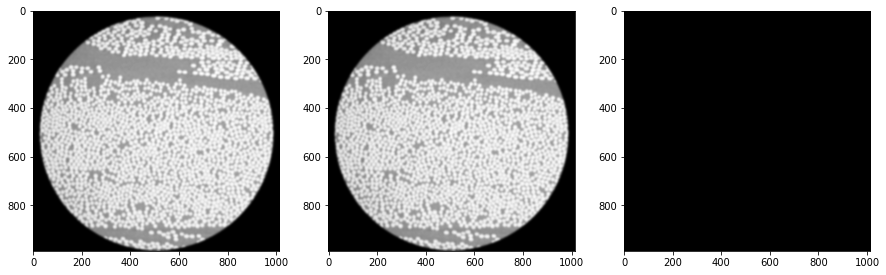

In [185]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(d2)
ax2.imshow(d1)
ax3.imshow(d2 - d1)

## Exercise 2
Difference between derivative of Gaussian image, and then

In [186]:
derive = gaussian_filter(arr, sigma, order=1)
img_then_derive = convolve1d(
    convolve1d(
    gaussian_filter(arr, sigma), weights=[.5, 0, -.5], axis=1)
    , weights=[.5, 0, -.5], axis=0
    )

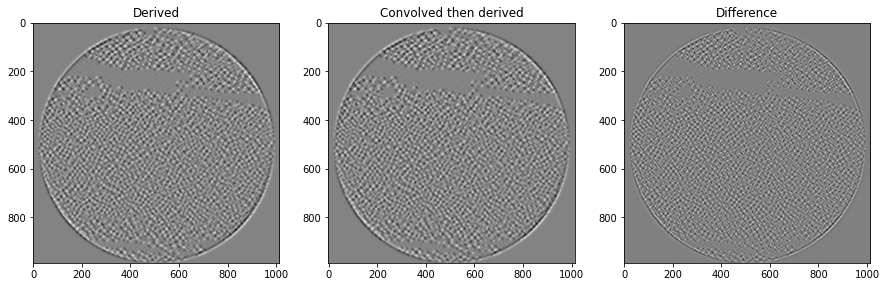

In [187]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(derive)
ax2.imshow(img_then_derive)
ax3.imshow(derive - img_then_derive)

ax1.set_title("Derived")
ax2.set_title("Convolved then derived")
ax3.set_title("Difference")

plt.show()

## Exercise 3
Difference between one big swoop of `t=20` and ten times `t=2`

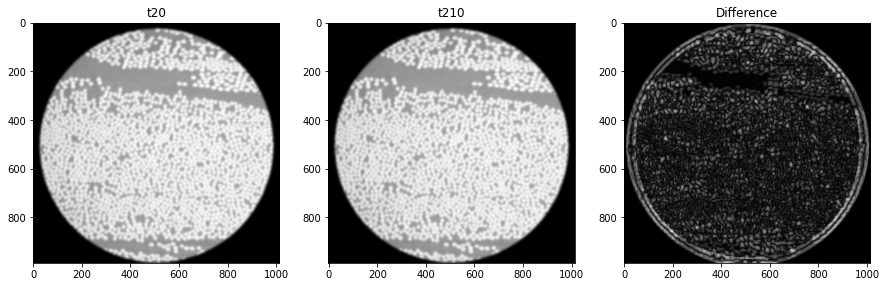

(2.5878775321564703e-06,)

In [188]:
t20 = gaussian_filter(arr, 20**.5)
t210 = arr
for _ in range(10):
    t210 = gaussian_filter(t210, 2**.5)

show_diff(t20, t210, "t20", "t210")
(abs(t20 - t210)).mean(), 

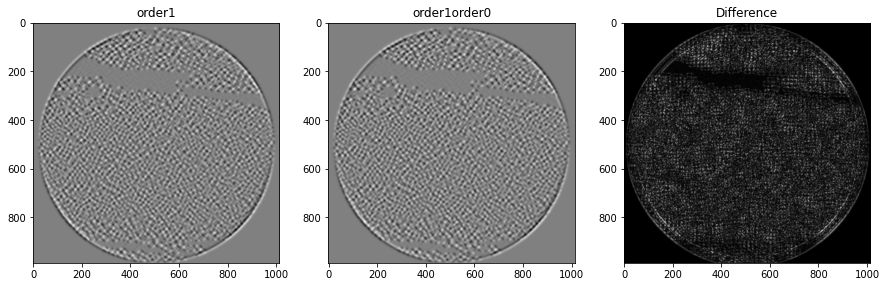

1.423493312061566e-07

In [189]:
order1 = gaussian_filter(arr, 20**.5, order=1)
order0order1 = gaussian_filter(
    gaussian_filter(
        arr, 10**.5, order=0
    ), 10**.5, order=1
)
show_diff(order1, order0order1, "order1", "order1order0")
np.median(abs(order1 - order0order1))

In [190]:
order1.dtype

dtype('float64')

# Segmentation
## Exercise 1
Segmentation

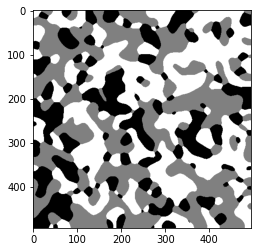

In [191]:
fuel1 = Image.open(path.join(data_path, "fuel_cells/fuel_cell_1.tif"))
fuel1_arr = np.asarray(fuel1)
plt.imshow(fuel1_arr)

In [192]:
def LenSegBoundary(arr: np.array) -> int:
    axis1 = (np.diff(arr, axis=1) > 0).sum()
    axis2 = (np.diff(arr, axis=0) > 0).sum()
    return axis1 + axis2

LenSegBoundary(fuel1_arr)

16328

# Curve Smoothing
## Exercise 1

In [193]:
dino_arr = np.loadtxt(path.join(data_path, "curves/dino_noisy.txt"))

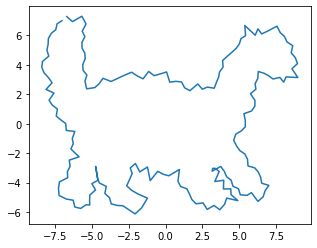

In [194]:
plt.plot(dino_arr[:, 0], dino_arr[:, 1])
plt.gca().set_aspect("equal")

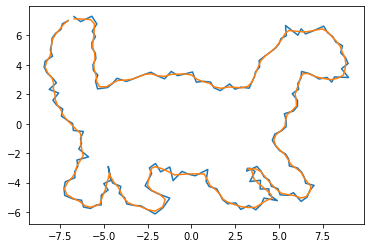

In [199]:
def iter_smooth(X, lambda_, t_):
    N = X.shape[0]
    I = np.eye(N)
    L = np.eye(N, k=-1) - 2 * np.eye(N) + np.eye(N, k=1)
    L[-1, 0] = 1
    L[0, -1] = 1
    out = X
    for _ in range(t_):
        out = (I + L * lambda_) @ out

    return out


iter_dino = iter_smooth(dino_arr, .25, 1)

plt.plot(dino_arr[:,0], dino_arr[:,1])
plt.plot(iter_dino[:,0], iter_dino[:,1])

In [208]:
# Answer to question 3 in quiz
answ = 0
for i in range(iter_dino.shape[0]):
    answ += np.sqrt(
        (iter_dino[i-1, 0] - iter_dino[i, 0])**2 + 
        (iter_dino[i-1, 1] - iter_dino[i, 1]) ** 2)
answ

77.37190409505688

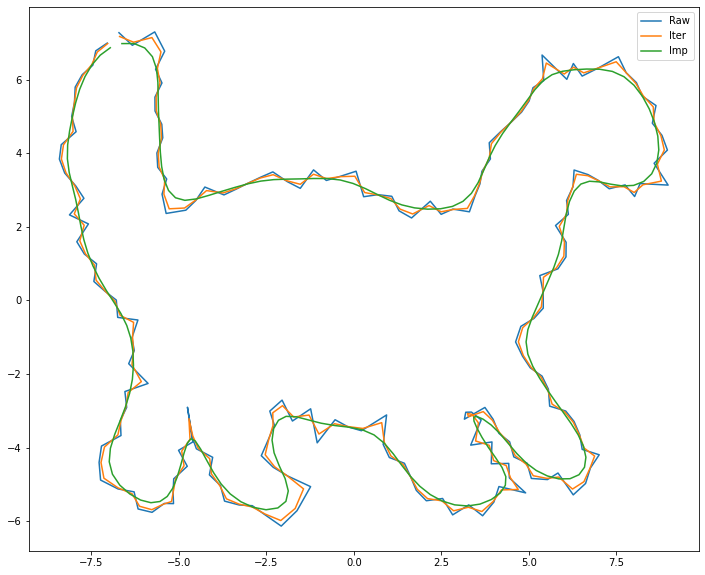

In [196]:
def imp_smooth(X, lambda_):
    N = X.shape[0]
    I = np.eye(N)
    L = np.eye(N, k=-1) - 2 * np.eye(N) + np.eye(N, k=1)
    L[-1, 0] = 1
    L[0, -1] = 1
    
    return np.linalg.inv(I - lambda_ * L) @ X

lambd = .3
imp_dino = imp_smooth(dino_arr, lambd)


plt.figure(figsize=(12, 10))
plt.plot(dino_arr[:,0], dino_arr[:,1])
plt.plot(imp_dino[:,0], imp_dino[:,1])
plt.plot(iter_dino[:,0], iter_dino[:,1])

plt.legend(["Raw", "Iter", "Imp"])

In [197]:
def generate_smooth_kernel(X, alpha_, beta_):
    N = X.shape[0]
    A = np.eye(N, k=-1) - 2 * np.eye(N) + np.eye(N, k=1)
    A[-1, 0] = 1
    A[0, -1] = 1

    B = -6 * np.eye(N) + 4 * np.eye(N, k=1) + 4 * np.eye(N, k=-1) + -1 * np.eye(N, k=-2) + -1 * np.eye(N, k=2)
    B[-1, 0] = 4
    B[-1, 1] = -1
    B[-2, 0] = -1
    B[0, -1] = 4
    B[1, -1] = -1
    B[0, -2] = -1
    assert np.sum(np.sum(B, axis=0)) == 0.0

    return alpha_ * A + beta_ * B

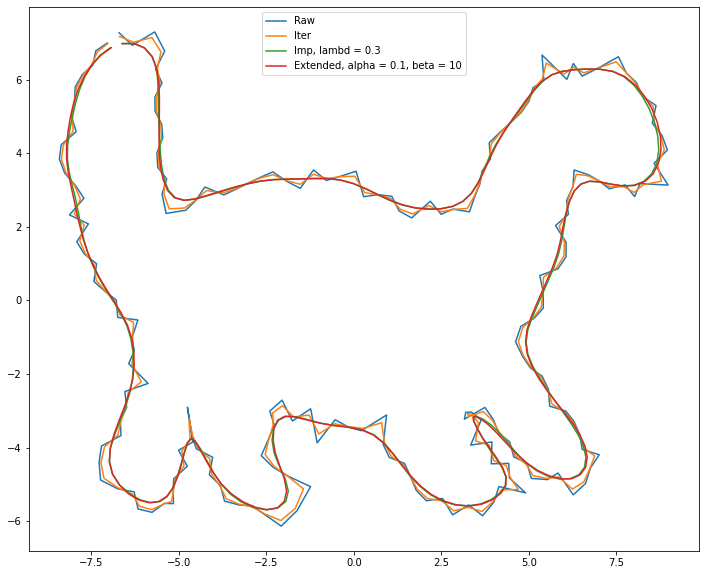

In [198]:
def imp_smooth_extended(X, alpha_, beta_):
    kernel = generate_smooth_kernel(X, alpha_, beta_)
    N = X.shape[0]
    I = np.eye(N)
    L = np.eye(N, k=-1) - 2 * np.eye(N) + np.eye(N, k=1)
    L[-1, 0] = 1
    L[0, -1] = 1
    
    return np.linalg.inv(I - kernel) @ X

alpha = .1
beta = 10
dino_extended = imp_smooth_extended(dino_arr, alpha, beta)

plt.figure(figsize=(12, 10))
plt.plot(dino_arr[:,0], dino_arr[:,1])
plt.plot(imp_dino[:,0], imp_dino[:,1])
plt.plot(iter_dino[:,0], iter_dino[:,1])
plt.plot(dino_extended[:,0], iter_dino[:,1])

plt.legend(["Raw", "Iter", f"Imp, {lambd = }", f"Extended, {alpha = }, {beta = }"])